# Retinotopic mapping - forward and reverse

The Oculomotor model has a retinotopic mapping between locations in the eye's frame of reference given by rotations about the $x$ and $y$ Cartesian axes ($\theta_x$ and $\theta_y$) and locations on the cortical surface which specify a radial and azimuthal angle, r and $\phi$. In the model, the mapping is applied in worldDataMaker.cpp, which creates all the retinal neuron locations in terms of r and $\phi$, then converts these into $\theta_x$ and $\theta_y$ in EyeFrame::generateNeuronThetaCoords, which contains an implementation of the mapping from (r,$\phi$) to ($\theta_x$,$\theta_y$). The reverse mapping is achieved in worldDataMaker.cpp because the neurons are stored in a container which retains the (r,$\phi$) information. If a given neuron at ($\theta_x$,$\theta_y$) is activated, then its position in the container encodes (r,$\phi$). For this reason there is no explicit sign of the reverse mapping in the EyeFrame code.

In this model, $\theta_x$ is a rotation about the Cartesian $x$ axis. The result of a positive rotation about the $x$ axis in a right-handed Cartesian coordinate system results in an "upward movement". Note that a positive rotation about the $y$ axis results in a "leftward movement". See worldtest_singlelum to see the result of the mapping (run worldtest_singlelum, then examine the results with worldtest_singlelum.m).

Here, I'm going to write out the retinotopic mappings, both forward and reverse. Starting from the mapping given in Alex and Kevin's paper "An integrative model...":

The magnification factor, $M_f$ is given by:
$$ M_f = {W_{nfs} \over E_2 ln ({W_{fov} \over 2 E_2} + 1)}  \tag{0}$$
where $W_{nfs}$ is the width of the retinotopic neural fields (50 for the oculomotor model), $W_{fov}$ is the eye's field of view, which is set to 61 degrees (a reduction from the biophysically accurate 150 degrees due to the small number of neurons in the retinotopic neural field). $E_2$ is the eccentricity (in degrees) at which the retinal neural density has halved compared with the foveal region.

Here's what $M_{f}(W_{fov})$ looks like:

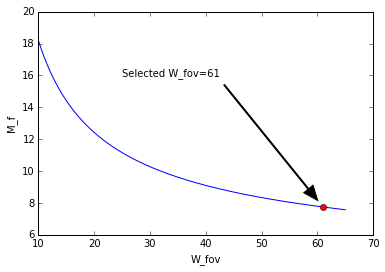

In [35]:
# Graph Mf(W_fov) here.
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# The parameters described above
W_nfs = 50
E_2 = 2.5

W_fov = np.linspace(10,65,500)
M_f = W_nfs / (E_2 * np.log ((W_fov/(2*E_2))+1))

plt.plot (W_fov,M_f)
plt.xlabel('W_fov')
plt.ylabel('M_f')

# Add dot for selected W_fov
W_fov_sel = 61
M_f_sel = W_nfs / (E_2 * np.log ((W_fov_sel/(2*E_2))+1))
plt.plot (W_fov_sel, M_f_sel, 'ro')
plt.annotate('Selected W_fov=61', xy=(W_fov_sel, M_f_sel), xytext=(25, 16),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1),
            )

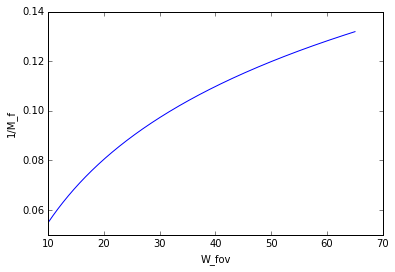

In [37]:
# Just testing; what's 1/M_f and can I use that to widen the gaussian projective field successfully?
%matplotlib inline

W_fov = np.linspace(10,65,500)
M_f_inv = 1/M_f

plt.plot (W_fov,M_f_inv)
plt.xlabel('W_fov')
plt.ylabel('1/M_f')

With $M_f$ calculated, the mapping from the retinotopic radial and angular components, $r$ and $\phi$ to $\theta_x$ and $\theta_y$ is:

$$ \theta_x = E_2 (e^{{r \over M_f E_2}} - 1).\cos({2 \pi \phi \over W_{nfs}}) \tag{1}$$

$$ \theta_y = E_2 (e^{{r \over M_f E_2}} - 1).\sin({2 \pi \phi \over W_{nfs}}) \tag{2}$$

The transformation given by (1) and (2) is the one implemented by the retmap function below.

Our next task is to find the reverse mapping; that is to find $\phi$ and $r$ in terms of  $\theta_x$ and $\theta_y$. First, let $m = {1 \over M_f E_2}$ and $k = {2 \pi \over W_{nfs}}$. Then:

$$ \theta_x = E_2 (e^{m r} - 1).\cos(k \phi)$$
$$ \theta_y = E_2 (e^{m r} - 1).\sin(k \phi)$$

$$ \implies E_2 (e^{m r} - 1) = {\theta_x \over \cos(k \phi)} = {\theta_y \over \sin(k \phi)} $$
$$ \implies { \sin(k \phi) \over \cos(k \phi) } = {\theta_y\over\theta_x}$$
$$ \implies \tan(k \phi) = {\theta_y\over\theta_x}$$
$$ \implies \phi = {1\over k} \arctan ({\theta_y\over\theta_x})$$
but *be careful about quadrants* - there are infinite solutions to $\arctan(x)$ for any $x$. Expanding k we get:
$$ \phi = {W_{nfs} \over 2 \pi}\arctan ({\theta_y\over\theta_x}) \tag{3}$$

Now back to 

$$ \theta_x = E_2 (e^{m r} - 1).\cos(k \phi)$$
$$ \theta_y = E_2 (e^{m r} - 1).\sin(k \phi)$$

to find $r$ in terms of $\theta_x$ and $\theta_y$. Square these:

$$ {\theta_x}^2 = {E_2}^2 (e^{m r} - 1)^2.\cos^2(k \phi)$$
$$ {\theta_y}^2 = {E_2}^2 (e^{m r} - 1)^2.\sin^2(k \phi)$$
$$ \implies {\theta_x}^2 + {\theta_y}^2 = {E_2}^2 (e^{m r} - 1)^2.(\cos^2(k \phi) + \sin^2(k \phi))$$
$$ \implies {\theta_x}^2 + {\theta_y}^2 = {E_2}^2 (e^{m r} - 1)^2$$
(by the Pythagorean trigonometric identity $\sin^2\theta + \cos^2\theta = 1$) and so:
$$ \sqrt{{\theta_x}^2 + {\theta_y}^2} =E_2 (e^{m r} - 1)$$
$$ \implies e^{m r} = {1\over E_2}\sqrt{{\theta_x}^2 + {\theta_y}^2}+1$$
$$ \implies r = {1\over m} \ln ({1\over E_2}\sqrt{{\theta_x}^2 + {\theta_y}^2}+1)$$
Expanding m we get:
$$ r = M_f E_2 \ln ({1\over E_2}\sqrt{{\theta_x}^2 + {\theta_y}^2}+1) \tag{4}$$
which bears a striking resemblence to (0).

##  Alternative mapping from Ottes et al 1986

Call this "otmap" perhaps. The equations for position, X, Y on the collicular surface, relating to a position R, $\theta$ on the retinal surface are:

$$ X = B_X \ln ({\sqrt{R^2 + 2AR\cos\theta + A^2 } \over A}) $$

$$ Y = B_Y \arctan ({ R\sin\theta \over R\cos\theta + A}) $$

Taking (one of the) the horizontal cases, for which $\theta=0$; $Y=0~\forall R$ and 

$$ X = B_X \ln ({\sqrt{R^2 + 2AR + A^2 } \over A}) = B_X \ln ({\sqrt{(R+A)^2} \over A}) = B_X \ln ({R+A \over A}) =  B_X \ln ({R\over A } + 1)$$

Which has the same form as eqn (0).

In [ ]:
# Graph Mf(W_fov) here.
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# The parameters described above
W_nfs = 50
E_2 = 2.5

W_fov = np.linspace(10,65,500)
M_f = W_nfs / (E_2 * np.log ((W_fov/(2*E_2))+1))

plt.plot (W_fov,M_f)
plt.xlabel('W_fov')
plt.ylabel('M_f')

# Add dot for selected W_fov
W_fov_sel = 61
M_f_sel = W_nfs / (E_2 * np.log ((W_fov_sel/(2*E_2))+1))
plt.plot (W_fov_sel, M_f_sel, 'ro')
plt.annotate('Selected W_fov=61', xy=(W_fov_sel, M_f_sel), xytext=(25, 16),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1),
            )

In [2]:
def retmap (r, phi):
    # Here's the mapping from retinotopic radial component (r) and
    # angular component (phi) to the eyeframe map thetaX/thetaY
    # (rotation _about_ x and y axes)

    import numpy as np

    E2 = float(2.5) # radial angle at which neural density has halved 
    nfs = float(50) # 50x50 grid.
    fieldOfView = float(61) # 0 and +/- 30 degrees
    # The Magnification factor
    Mf = nfs/(E2*np.log(((fieldOfView/2)/E2+1)))

    _r = float(r)
    _phi = float(phi)
    
    thetax = E2*(-1+np.exp(_r/(Mf*E2)))*np.cos(_phi*2*np.pi/nfs)
    thetay = E2*(-1+np.exp(_r/(Mf*E2)))*np.sin(_phi*2*np.pi/nfs)

    print 'RotX:',thetax,'RotY:',thetay
    
    return thetax,thetay

In [12]:
# Test retmap()
print ("Physically UP:")
thx,thy = retmap (31.18804,50)
print ("RIGHT:")
thx,thy = retmap (31.18804,37.5)
print ("DOWN:")
thx,thy = retmap (31.18804,25)
print ("LEFT:")
thx,thy = retmap (31.18804,12.5)

print ("XTRA:")
thx,thy = retmap (24,12.5)


Physically UP:
RotX: 10.0000025171 RotY: -2.4492942148e-15
RIGHT:
RotX: -1.8369706611e-15 RotY: -10.0000025171
DOWN:
RotX: -10.0000025171 RotY: 1.2246471074e-15
LEFT:
RotX: 6.123235537e-16 RotY: 10.0000025171
XTRA:
RotX: 3.75116662734e-16 RotY: 6.12612000448


In [243]:
def mapret (thetax, thetay):
    # mapping from eyeframe map to retinotopic coordinates.

    import numpy as np
    
    E2 = float(2.5) # radial angle at which neural density has halved 
    nfs = float(50.0) # 50x50 grid.
    fieldOfView = float(61.0) # 0 and +/- 30 degrees
    # The Magnification factor
    Mf = nfs/(E2*np.log(((fieldOfView/2)/E2)+1))

    _thetay = float(thetay)
    _thetax = float(thetax)
    print 'thetax =',thetax,'thetay =',thetay
    
    # From arctan alone, you can only get a value for phi between -pi/2 to pi/2 (or 
    # from 0 to pi). To cover the full range of phi, you have to make use of the
    # quadrant information and add +/-pi. arctan2 does this for you, but it returns
    # a value between -pi and pi, whereas I want a value between 0 and 2pi, hence the
    # test for phi<0.
    phi = (nfs/(2*np.pi))*np.arctan2 (_thetay,_thetax)
    if phi < 0:
        phi = phi + nfs;

    # Calculate r
    r = Mf*E2*np.log( (1/E2) * np.sqrt(_thetax*_thetax + _thetay*_thetay) + 1 )
    
    print 'r =', r, 'phi =', phi
    
    return r, phi

In [246]:
# Test mapret. e.g.: RotX = 0, RotY = -10 (a rightward position)
r, phi = mapret (0.0,-10)

thetax = 0.0 thetay = -10
r = 31.1880360979 phi = 37.5


In [249]:
# Verify forward/reverse mappings:
r,phi = mapret (5,5)
thx,thy = retmap (r,phi)
print '---'
r,phi = mapret (-5,-5)
thx,thy = retmap (r,phi)
print '==='
r,phi = mapret (-5,5)
thx,thy = retmap (r,phi)
print '---'
r,phi = mapret (5,-5)
thx,thy = retmap (r,phi)
print '==='
r,phi = mapret (5,0) # UP
thx,thy = retmap (r,phi)
print '---'
r,phi = mapret (-5,0) # DOWN
thx,thy = retmap (r,phi)
print '==='
r,phi = mapret (0,-5) # LEFT
thx,thy = retmap (r,phi)
print '---'
r,phi = mapret (0,5) # RIGHT
thx,thy = retmap (r,phi)
print '==='



thetax = 5 thetay = 5
r = 26.0143649762 phi = 6.25
RotX: 5.0 RotY: 5.0
---
thetax = -5 thetay = -5
r = 26.0143649762 phi = 31.25
RotX: -5.0 RotY: -5.0
===
thetax = -5 thetay = 5
r = 26.0143649762 phi = 18.75
RotX: -5.0 RotY: 5.0
---
thetax = 5 thetay = -5
r = 26.0143649762 phi = 43.75
RotX: 5.0 RotY: -5.0
===
thetax = 5 thetay = 0
r = 21.2891466343 phi = 0.0
RotX: 5.0 RotY: 0.0
---
thetax = -5 thetay = 0
r = 21.2891466343 phi = 25.0
RotX: -5.0 RotY: 6.12323399574e-16
===
thetax = 0 thetay = -5
r = 21.2891466343 phi = 37.5
RotX: -9.18485099361e-16 RotY: -5.0
---
thetax = 0 thetay = 5
r = 21.2891466343 phi = 12.5
RotX: 3.06161699787e-16 RotY: 5.0
===


r = 6.52023180305 phi = 37.5795774715
r = 6.52023180305 phi = 38.8595883056
r = 6.52023180305 phi = 40.1395991397
r = 6.52023180305 phi = 41.4196099737
r = 6.52023180305 phi = 42.6996208078
r = 6.52023180305 phi = 43.9796316419
r = 6.52023180305 phi = 45.2596424759
r = 6.52023180305 phi = 46.53965331
r = 6.52023180305 phi = 47.819664144
r = 6.52023180305 phi = 49.0996749781
r = 6.52023180305 phi = 0.379685812175
r = 6.52023180305 phi = 1.65969664624
r = 6.52023180305 phi = 2.9397074803
r = 6.52023180305 phi = 4.21971831436
r = 6.52023180305 phi = 5.49972914843
r = 6.52023180305 phi = 6.77973998249
r = 6.52023180305 phi = 8.05975081655
r = 6.52023180305 phi = 9.33976165062
r = 6.52023180305 phi = 10.6197724847
r = 6.52023180305 phi = 11.8997833187
r = 6.52023180305 phi = 13.1797941528
r = 6.52023180305 phi = 14.4598049869
r = 6.52023180305 phi = 15.7398158209
r = 6.52023180305 phi = 17.019826655
r = 6.52023180305 phi = 18.2998374891
r = 6.52023180305 phi = 19.5798483231
r = 6.5202318030

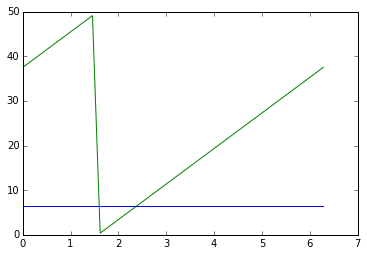

In [229]:
import numpy as np
phis = []
x = np.linspace(0.01,2*np.pi,40,endpoint=True)
for i in range(0, 40):
    #if i%10==0:
        #print 'x:',np.sin(x[i]),' y:', -1*np.cos(x[i])
    phi = mapret ( np.sin(x[i]) , -1*np.cos(x[i]) )
    phis.append(phi);

import matplotlib.pyplot as plt
plt.plot (x,phis)
plt.show()

(-1.5707963267948966, 1.5707963267948966)

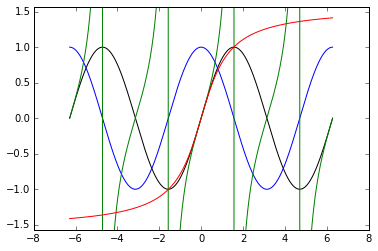

In [248]:
# Scratchpad; Looking at arctan.

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

x = np.linspace(-2*np.pi, 2*np.pi, 5000)

sinx = np.sin(x)
cosx = np.cos(x)
tanx = np.tan(x)
atanx = np.arctan(x)

plt.plot(x, sinx, 'k')
plt.plot(x, cosx, 'b')
plt.plot(x, tanx, 'g')
plt.plot(x, atanx, 'r')
plt.ylim((-np.pi/2,np.pi/2))